# Regresión Lineal Múltiple para Predicción de Precios de Viviendas en Boston

Este notebook demuestra el análisis de regresión lineal múltiple en el dataset de Boston Housing para predecir precios de viviendas basándose en varias características.


In [97]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

# Para mejorar la visualización
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 2. Cargar el Dataset


In [98]:
# El CSV no tiene encabezados, por lo que necesitamos especificar los nombres de columnas
column_names = [
    "CRIM",  # tasa de criminalidad per cápita por ciudad
    "ZN",  # proporción de terreno residencial zonificado para lotes de más de 25,000 pies cuadrados
    "INDUS",  # proporción de acres de negocios no minoristas por ciudad
    "CHAS",  # variable dummy del río Charles (1 si limita con el río; 0 en caso contrario)
    "NOX",  # concentración de óxidos nítricos (partes por 10 millones)
    "RM",  # número promedio de habitaciones por vivienda
    "AGE",  # proporción de unidades ocupadas por propietarios construidas antes de 1940
    "DIS",  # distancias ponderadas a cinco centros de empleo de Boston
    "RAD",  # índice de accesibilidad a autopistas radiales
    "TAX",  # tasa de impuesto a la propiedad de valor completo por $10,000
    "PTRATIO",  # relación alumno-maestro por ciudad
    "B",  # proporción de residentes afroamericanos por ciudad
    "LSTAT",  # % de población de estatus bajo
    "MEDV",  # Valor medio de viviendas ocupadas por propietarios en $1000s (OBJETIVO)
]

data = pd.read_csv(
    "../data/housing.csv",
    sep=r"\s+",
    names=column_names,
    header=None,
)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [100]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [101]:
print("Valores faltantes por columna:")
display(data.isnull().sum())
print(f"Total de valores faltantes: {data.isnull().sum().sum()}")

Valores faltantes por columna:


CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Total de valores faltantes: 0


## 3. Análisis Exploratorio de Datos (EDA)


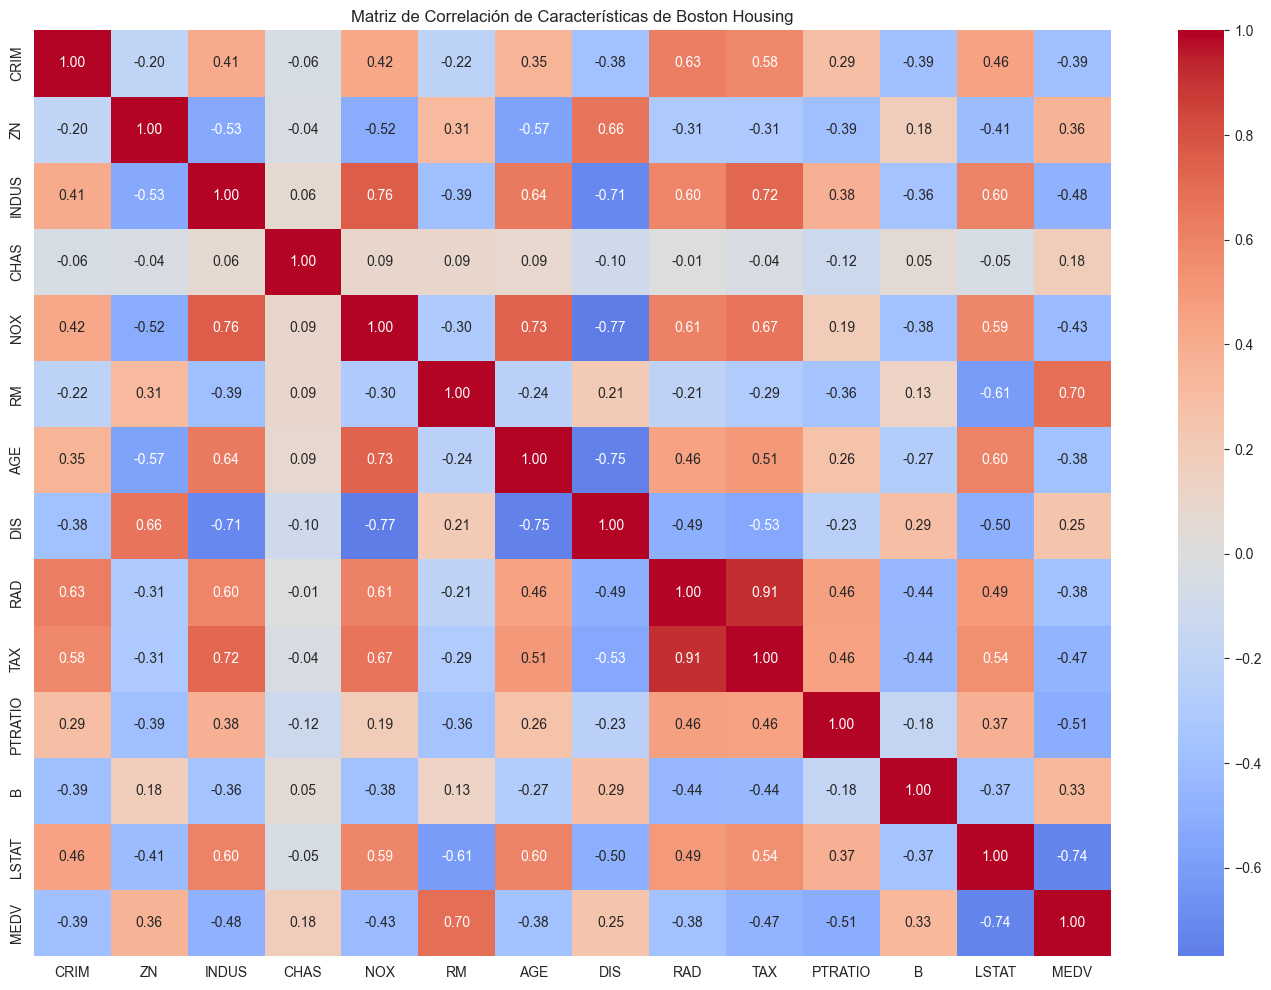

In [102]:
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Matriz de Correlación de Características de Boston Housing")
plt.tight_layout()
plt.show()

In [103]:
# Correlación con variable objetivo (MEDV)
correlations = data.corr()["MEDV"].sort_values(ascending=False)
print("Correlación con MEDV (objetivo):")
print(correlations)

Correlación con MEDV (objetivo):
MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64


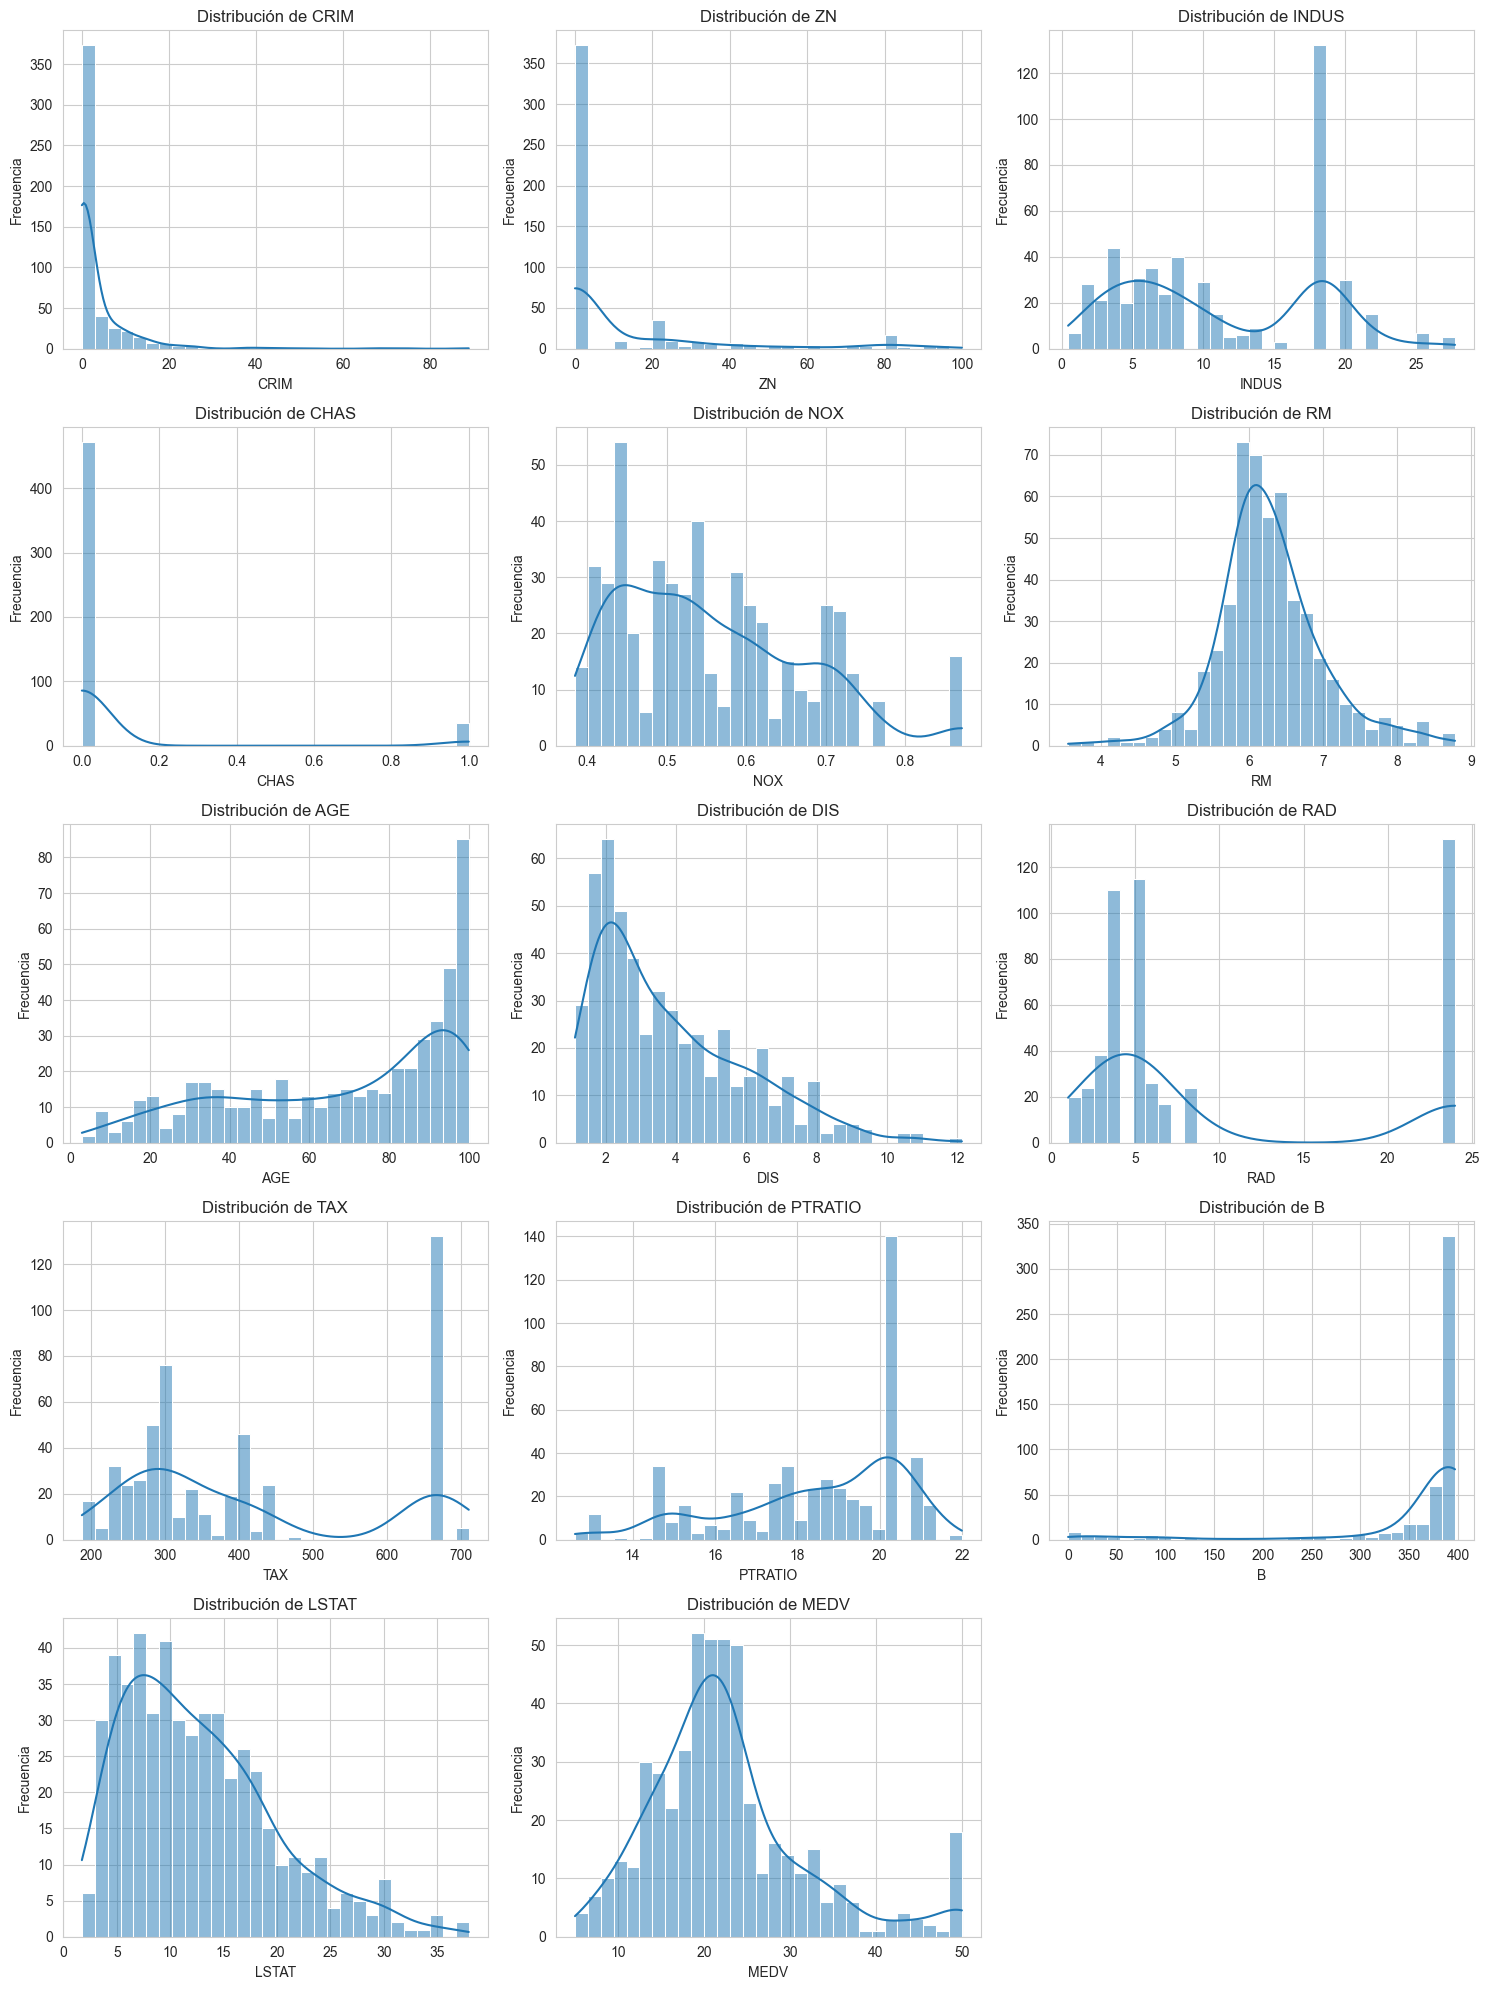

In [104]:
# Histogramas de las características
numeric_cols = data.select_dtypes(include=[np.number]).columns
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=data, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")

# Ocultar subplots no utilizados
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

Características principales correlacionadas con MEDV: ['MEDV', 'LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX']


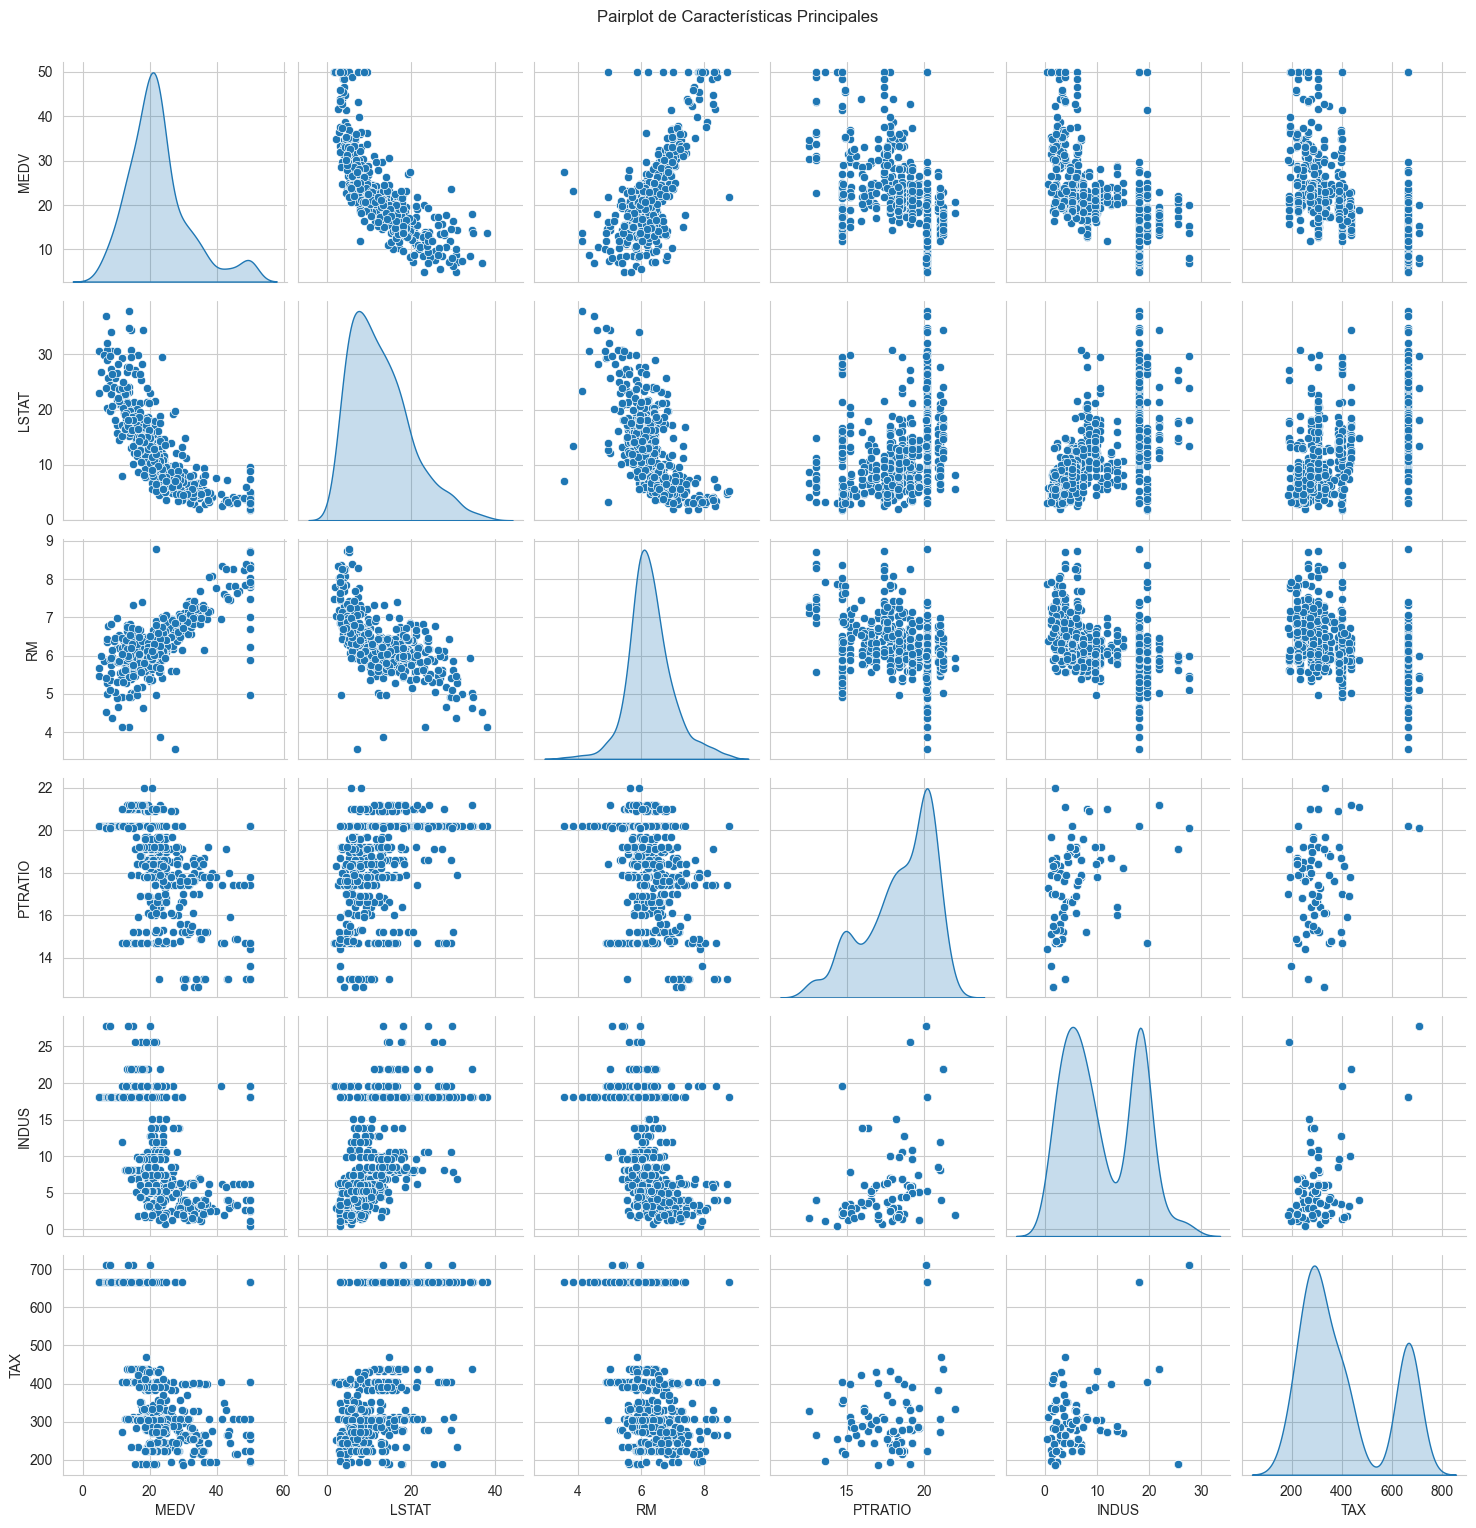

In [105]:
# Pairplot para características principales correlacionadas con MEDV
top_features = correlations.abs().sort_values(ascending=False).head(6).index.tolist()
print(f"Características principales correlacionadas con MEDV: {top_features}")

sns.pairplot(data[top_features], diag_kind="kde")
plt.suptitle("Pairplot de Características Principales", y=1.02)
plt.show()

## 4. Preprocesamiento de Datos


In [106]:
# Verificar si hay valores faltantes a manejar
if data.isnull().sum().sum() > 0:
    print("Manejando valores faltantes...")
    data = data.dropna()
else:
    print("No se encontraron valores faltantes.")

print(f"\nForma del dataset: {data.shape}")

No se encontraron valores faltantes.

Forma del dataset: (506, 14)


In [107]:
# Definir características (X) y variable objetivo (y)
feature_cols = [
    "CRIM",
    "ZN",
    "INDUS",
    "CHAS",
    "NOX",
    "RM",
    "AGE",
    "DIS",
    "RAD",
    "TAX",
    "PTRATIO",
    "B",
    "LSTAT",
]
target_col = "MEDV"

X = data[feature_cols]
y = data[target_col]

print(f"Forma de características: {X.shape}")
print(f"Forma de objetivo: {y.shape}")

Forma de características: (506, 13)
Forma de objetivo: (506,)


## 5. Regresión Lineal Simple (Una Característica)

Comencemos con una regresión lineal simple usando la característica con mayor correlación (LSTAT o RM).


In [108]:
# Regresión lineal simple con RM (número promedio de habitaciones)
formula_simple = "MEDV ~ RM"
lm_simple = smf.ols(formula=formula_simple, data=data).fit()
print(lm_simple.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Sat, 18 Oct 2025   Prob (F-statistic):           2.49e-74
Time:                        14:36:47   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

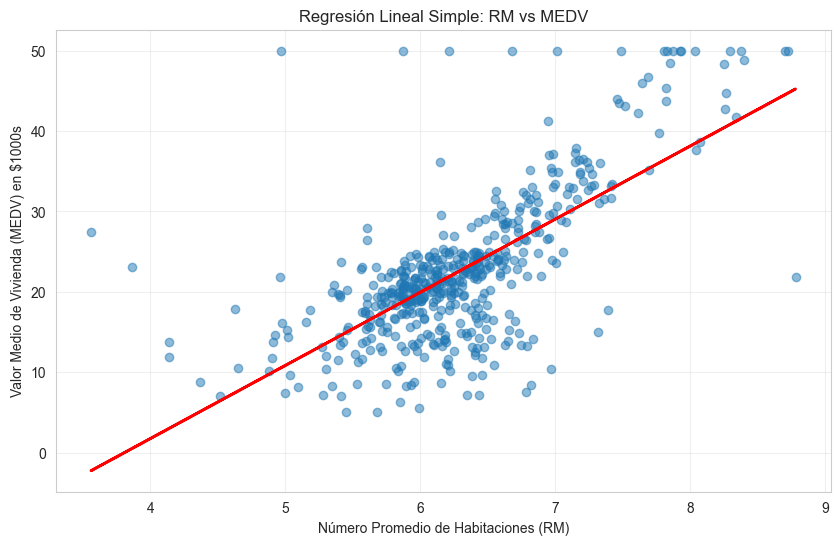


R-cuadrado: 0.4835
Coeficiente (pendiente): 9.1021
Intercepto: -34.6706


In [109]:
# Visualizar regresión lineal simple
plt.figure(figsize=(10, 6))
plt.scatter(data["RM"], data["MEDV"], alpha=0.5)
plt.plot(data["RM"], lm_simple.predict(data), color="red", linewidth=2)
plt.xlabel("Número Promedio de Habitaciones (RM)")
plt.ylabel("Valor Medio de Vivienda (MEDV) en $1000s")
plt.title("Regresión Lineal Simple: RM vs MEDV")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nR-cuadrado: {lm_simple.rsquared:.4f}")
print(f"Coeficiente (pendiente): {lm_simple.params['RM']:.4f}")
print(f"Intercepto: {lm_simple.params['Intercept']:.4f}")

## 6. Regresión Lineal Múltiple con Statsmodels

Ahora construiremos varios modelos de regresión con diferentes combinaciones de características.


In [110]:
# Modelo 1: Dos características (RM y LSTAT - características más correlacionadas)
formula_1 = "MEDV ~ RM + LSTAT"
lm1 = smf.ols(formula=formula_1, data=data).fit()
print("Modelo 1: Dos Características (RM + LSTAT)")
print("=" * 50)
print(f"R-cuadrado: {lm1.rsquared:.4f}")
print(f"R-cuadrado ajustado: {lm1.rsquared_adj:.4f}")
print("\nCoeficientes:")
print(lm1.params)
print("\np-valores:")
print(lm1.pvalues)

Modelo 1: Dos Características (RM + LSTAT)
R-cuadrado: 0.6386
R-cuadrado ajustado: 0.6371

Coeficientes:
Intercept   -1.358273
RM           5.094788
LSTAT       -0.642358
dtype: float64

p-valores:
Intercept    6.687649e-01
RM           3.472258e-27
LSTAT        6.669365e-41
dtype: float64


In [111]:
# Modelo 2: Cinco características (características principales correlacionadas)
formula_2 = "MEDV ~ RM + LSTAT + PTRATIO + INDUS + TAX"
lm2 = smf.ols(formula=formula_2, data=data).fit()
print("Modelo 2: Cinco Características")
print("=" * 50)
print(f"R-cuadrado: {lm2.rsquared:.4f}")
print(f"R-cuadrado ajustado: {lm2.rsquared_adj:.4f}")
print("\nCoeficientes:")
print(lm2.params)
print("\np-valores:")
print(lm2.pvalues)

Modelo 2: Cinco Características
R-cuadrado: 0.6804
R-cuadrado ajustado: 0.6772

Coeficientes:
Intercept    17.517713
RM            4.625169
LSTAT        -0.559005
PTRATIO      -0.876154
INDUS         0.056975
TAX          -0.003537
dtype: float64

p-valores:
Intercept    1.283458e-05
RM           2.369663e-24
LSTAT        4.271308e-27
PTRATIO      8.935598e-12
INDUS        2.801512e-01
TAX          9.707194e-02
dtype: float64


In [112]:
# Modelo 3: Todas las características
formula_3 = "MEDV ~ CRIM + ZN + INDUS + CHAS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT"
lm3 = smf.ols(formula=formula_3, data=data).fit()
print("Modelo 3: Todas las Características")
print("=" * 50)
print(lm3.summary())

Modelo 3: Todas las Características
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 18 Oct 2025   Prob (F-statistic):          6.72e-135
Time:                        14:36:47   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36

In [113]:
# Calcular RSE (Error Estándar Residual) para cada modelo
def calculate_rse(y_true, y_pred, n_features):
    n = len(y_true)
    ssd = np.sum((y_true - y_pred) ** 2)
    rse = np.sqrt(ssd / (n - n_features - 1))
    return rse


y_pred_1 = lm1.predict(data)
rse_1 = calculate_rse(data["MEDV"], y_pred_1, 2)
print(f"RSE Modelo 1: {rse_1:.4f}")
print(f"RSE/Media Modelo 1: {rse_1 / data['MEDV'].mean():.2%}")

y_pred_2 = lm2.predict(data)
rse_2 = calculate_rse(data["MEDV"], y_pred_2, 5)
print(f"\nRSE Modelo 2: {rse_2:.4f}")
print(f"RSE/Media Modelo 2: {rse_2 / data['MEDV'].mean():.2%}")

y_pred_3 = lm3.predict(data)
rse_3 = calculate_rse(data["MEDV"], y_pred_3, 13)
print(f"\nRSE Modelo 3: {rse_3:.4f}")
print(f"RSE/Media Modelo 3: {rse_3 / data['MEDV'].mean():.2%}")

RSE Modelo 1: 5.5403
RSE/Media Modelo 1: 24.59%

RSE Modelo 2: 5.2253
RSE/Media Modelo 2: 23.19%

RSE Modelo 3: 4.7453
RSE/Media Modelo 3: 21.06%


## 7. Selección de Características con RFE de scikit-learn


In [114]:
# Eliminación Recursiva de Características
reg = LinearRegression()
n_features_to_select = 5  # Seleccionar las 5 mejores características
selector = RFE(reg, n_features_to_select=n_features_to_select, step=1)
selector.fit(X, y)

print("Resultados de Selección de Características:")
print("=" * 50)
print(f"Características seleccionadas (booleano): {selector.support_}")
print(f"Ranking de características: {selector.ranking_}")

selected_features = X.columns[selector.support_].tolist()
print(f"\nNombres de características seleccionadas: {selected_features}")

# Crear un DataFrame mostrando resultados de selección de características
feature_selection_df = pd.DataFrame(
    {
        "Feature": X.columns,
        "Seleccionada": selector.support_,
        "Ranking": selector.ranking_,
    }
)
feature_selection_df = feature_selection_df.sort_values("Ranking")
print("\nTabla de Selección de Características:")
print(feature_selection_df)

Resultados de Selección de Características:
Características seleccionadas (booleano): [False False False  True  True  True False  True False False  True False
 False]
Ranking de características: [4 6 5 1 1 1 9 1 3 7 1 8 2]

Nombres de características seleccionadas: ['CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO']

Tabla de Selección de Características:
    Feature  Seleccionada  Ranking
3      CHAS          True        1
4       NOX          True        1
5        RM          True        1
7       DIS          True        1
10  PTRATIO          True        1
12    LSTAT         False        2
8       RAD         False        3
0      CRIM         False        4
2     INDUS         False        5
1        ZN         False        6
9       TAX         False        7
11        B         False        8
6       AGE         False        9


## 8. División Train-Test y Evaluación del Modelo


In [115]:
# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.2, random_state=42
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")
print(f"Características utilizadas: {len(selected_features)}")

Tamaño del conjunto de entrenamiento: 404
Tamaño del conjunto de prueba: 102
Características utilizadas: 5


In [116]:
# Entrenar el modelo con características seleccionadas
model = LinearRegression()
model.fit(X_train, y_train)

print(f"Intercepto: {model.intercept_:.4f}")
print("\nCoeficientes de características:")
print("=" * 50)
for feature, coef in zip(selected_features, model.coef_):
    print(f"  {feature:12s}: {coef:8.4f}")

Intercepto: 22.4548

Coeficientes de características:
  CHAS        :   4.6212
  NOX         : -32.3792
  RM          :   6.8814
  DIS         :  -1.0060
  PTRATIO     :  -1.1793


In [117]:
# Hacer predicciones
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluar el modelo
print("Rendimiento en Conjunto de Entrenamiento:")
print("=" * 50)
print(f"  Puntaje R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"  MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")

print("\nRendimiento en Conjunto de Prueba:")
print("=" * 50)
print(f"  Puntaje R²: {r2_score(y_test, y_test_pred):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

# Verificar sobreajuste
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
r2_diff = train_r2 - test_r2

print(f"\nDiferencia de R² (train - test): {r2_diff:.4f}")
if r2_diff > 0.1:
    print(
        "⚠️  Advertencia: El modelo podría estar sobreajustado (diferencia de R² > 0.1)"
    )
else:
    print("✓ El modelo muestra buena generalización")

Rendimiento en Conjunto de Entrenamiento:
  Puntaje R²: 0.6503
  RMSE: 5.5117
  MAE: 3.8490

Rendimiento en Conjunto de Prueba:
  Puntaje R²: 0.5432
  RMSE: 5.7876
  MAE: 3.6210

Diferencia de R² (train - test): 0.1071
⚠️  Advertencia: El modelo podría estar sobreajustado (diferencia de R² > 0.1)


In [118]:
# Análisis estadístico completo usando statsmodels sobre el conjunto de entrenamiento
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Ajustar modelo con statsmodels
model_sm = sm.OLS(y_train, X_train_sm).fit()

print("=" * 70)
print("MODELO 5 (RFE) - ANÁLISIS ESTADÍSTICO COMPLETO")
print("=" * 70)
print(model_sm.summary())

# Calcular RSE para el modelo de entrenamiento
n = len(y_train)
p = len(selected_features)
rse_model5 = np.sqrt(
    np.sum((y_train - model_sm.predict(X_train_sm)) ** 2) / (n - p - 1)
)

print("\n" + "=" * 70)
print("MÉTRICAS ESTADÍSTICAS DEL MODELO FINAL")
print("=" * 70)
print(f"R²: {model_sm.rsquared:.4f}")
print(f"R² Ajustado: {model_sm.rsquared_adj:.4f}")
print(f"Estadístico F: {model_sm.fvalue:.4f}")
print(f"p-valor (F-statistic): {model_sm.f_pvalue:.4e}")
print(f"RSE: {rse_model5:.4f}")

# Validación en test set
y_test_pred_sm = model_sm.predict(X_test_sm)
test_r2_sm = r2_score(y_test, y_test_pred_sm)
test_rmse_sm = np.sqrt(mean_squared_error(y_test, y_test_pred_sm))

print(f"\n--- Validación en Test Set ---")
print(f"R² (Test): {test_r2_sm:.4f}")
print(f"RMSE (Test): {test_rmse_sm:.4f}")

# Tabla de coeficientes con significancia estadística
print("\n" + "=" * 70)
print("COEFICIENTES Y SIGNIFICANCIA ESTADÍSTICA")
print("=" * 70)
coef_df = pd.DataFrame(
    {
        "Característica": ["Intercepto"] + selected_features,
        "Coeficiente": model_sm.params.values,
        "Error Estándar": model_sm.bse.values,
        "p-valor": model_sm.pvalues.values,
        "Significativo (α=0.05)": [
            "✓" if p < 0.05 else "✗" for p in model_sm.pvalues.values
        ],
    }
)
print(coef_df.to_string(index=False))

# Interpretación de significancia
print(f"\n--- Interpretación ---")
significant_features = [
    feat
    for feat, pval in zip(["Intercepto"] + selected_features, model_sm.pvalues.values)
    if pval < 0.05
]
print(
    f"Características estadísticamente significativas (p < 0.05): {len(significant_features)}/{len(selected_features) + 1}"
)
print(f"Variables significativas: {', '.join(significant_features)}")

MODELO 5 (RFE) - ANÁLISIS ESTADÍSTICO COMPLETO
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     148.0
Date:                Sat, 18 Oct 2025   Prob (F-statistic):           1.76e-88
Time:                        14:36:47   Log-Likelihood:                -1262.8
No. Observations:                 404   AIC:                             2538.
Df Residuals:                     398   BIC:                             2562.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

## 9. Análisis de Residuos


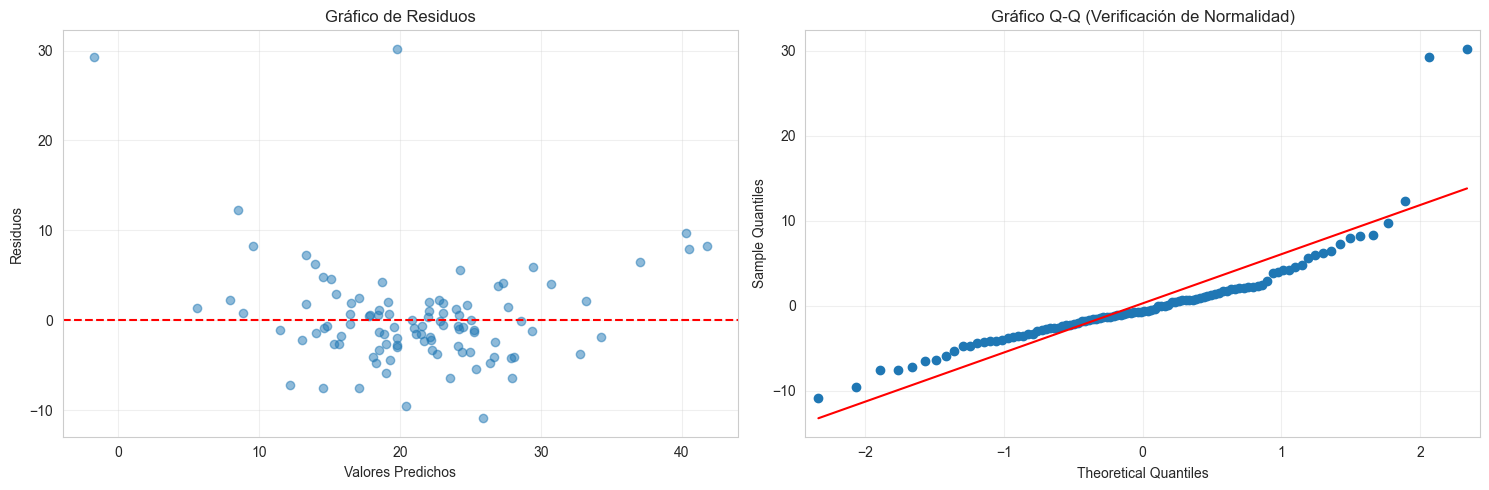

In [119]:
# Calcular residuos
residuals = y_test - y_test_pred

# Graficar residuos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de residuos
axes[0].scatter(y_test_pred, residuals, alpha=0.5)
axes[0].axhline(y=0, color="r", linestyle="--")
axes[0].set_xlabel("Valores Predichos")
axes[0].set_ylabel("Residuos")
axes[0].set_title("Gráfico de Residuos")
axes[0].grid(True, alpha=0.3)

# Gráfico Q-Q para normalidad
sm.qqplot(residuals, line="s", ax=axes[1])
axes[1].set_title("Gráfico Q-Q (Verificación de Normalidad)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

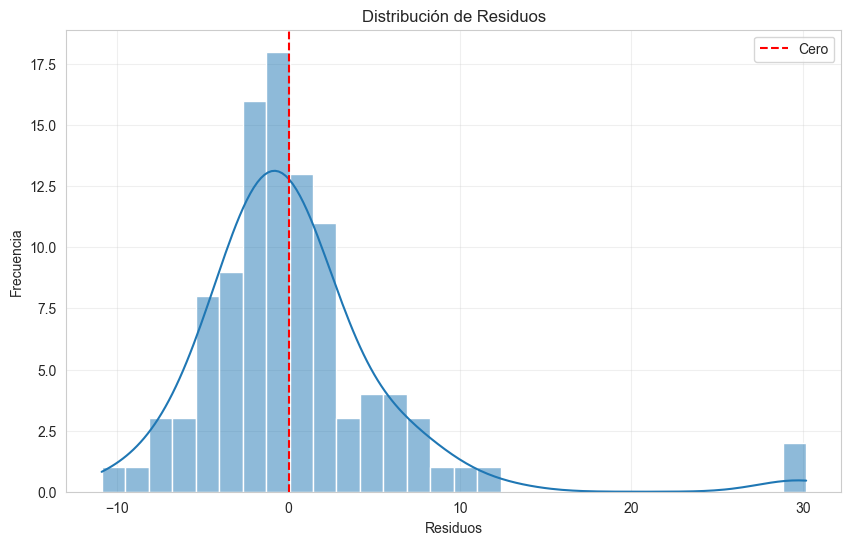

Media de residuos: 0.2683 (debería estar cerca de 0)
Desviación estándar de residuos: 5.8100


In [120]:
# Distribución de residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Distribución de Residuos")
plt.axvline(x=0, color="r", linestyle="--", label="Cero")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Media de residuos: {residuals.mean():.4f} (debería estar cerca de 0)")
print(f"Desviación estándar de residuos: {residuals.std():.4f}")

## 10. Predicciones vs Valores Reales


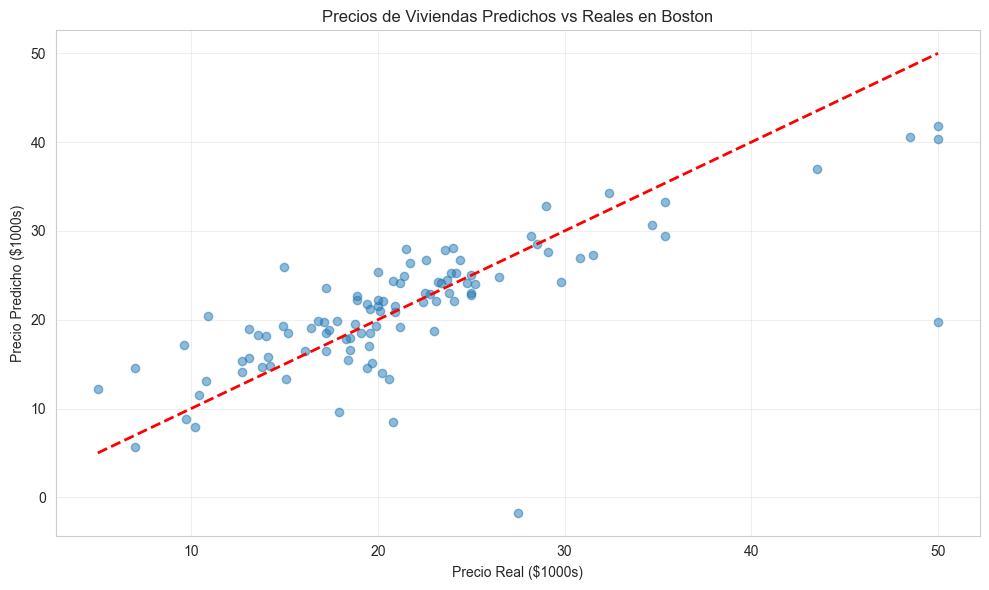

In [121]:
# Graficar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Precio Real ($1000s)")
plt.ylabel("Precio Predicho ($1000s)")
plt.title("Precios de Viviendas Predichos vs Reales en Boston")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Resumen de Comparación de Modelos


In [122]:
# Crear una tabla de comparación integral de diferentes modelos
model_comparison = pd.DataFrame(
    {
        "Modelo": [
            "Modelo 1 (solo RM)",
            "Modelo 2 (RM + LSTAT)",
            "Modelo 3 (5 características)",
            "Modelo 4 (Todas las 13 características)",
            "Modelo 5 (RFE - 7 características)",
        ],
        "Definición": [
            "MEDV ~ RM",
            "MEDV ~ RM + LSTAT",
            "MEDV ~ RM + LSTAT + PTRATIO + INDUS + TAX",
            "MEDV ~ Todas las características",
            f"MEDV ~ {' + '.join(selected_features)}",
        ],
        "# Características": [1, 2, 5, 13, len(selected_features)],
        "R²": [
            lm_simple.rsquared,
            lm1.rsquared,
            lm2.rsquared,
            lm3.rsquared,
            r2_score(y_test, y_test_pred),
        ],
        "R² Ajustado": [
            lm_simple.rsquared_adj,
            lm1.rsquared_adj,
            lm2.rsquared_adj,
            lm3.rsquared_adj,
            None,  # No disponible para división train-test
        ],
        "Estadístico F": [
            lm_simple.fvalue,
            lm1.fvalue,
            lm2.fvalue,
            lm3.fvalue,
            None,  # No disponible para división train-test
        ],
        "p-valor": [
            lm_simple.f_pvalue,
            lm1.f_pvalue,
            lm2.f_pvalue,
            lm3.f_pvalue,
            None,  # No disponible para división train-test
        ],
        "RSE": [
            calculate_rse(data["MEDV"], lm_simple.predict(data), 1),
            rse_1,
            rse_2,
            rse_3,
            None,
        ],
        "RMSE (Test)": [
            None,
            None,
            None,
            None,
            np.sqrt(mean_squared_error(y_test, y_test_pred)),
        ],
        "Error %": [
            (
                calculate_rse(data["MEDV"], lm_simple.predict(data), 1)
                / data["MEDV"].mean()
            )
            * 100,
            (rse_1 / data["MEDV"].mean()) * 100,
            (rse_2 / data["MEDV"].mean()) * 100,
            (rse_3 / data["MEDV"].mean()) * 100,
            (np.sqrt(mean_squared_error(y_test, y_test_pred)) / y_test.mean()) * 100,
        ],
    }
)

print("\n" + "=" * 200)
print("RESUMEN DE LAS REGRESIONES LINEALES - Comparación de Modelos")
print("=" * 200)
print(model_comparison.to_string(index=False))
print("=" * 200)


RESUMEN DE LAS REGRESIONES LINEALES - Comparación de Modelos
                                 Modelo                                Definición  # Características       R²  R² Ajustado  Estadístico F       p-valor      RSE  RMSE (Test)   Error %
                     Modelo 1 (solo RM)                                 MEDV ~ RM                  1 0.483525     0.482501     471.846740  2.487229e-74 6.616160          NaN 29.362342
                  Modelo 2 (RM + LSTAT)                         MEDV ~ RM + LSTAT                  2 0.638562     0.637124     444.330892 7.008455e-112 5.540257          NaN 24.587516
           Modelo 3 (5 características) MEDV ~ RM + LSTAT + PTRATIO + INDUS + TAX                  5 0.680410     0.677214     212.900683 2.372842e-121 5.225268          NaN 23.189600
Modelo 4 (Todas las 13 características)          MEDV ~ Todas las características                 13 0.740643     0.733790     108.076666 6.722175e-135 4.745298          NaN 21.059508
     Modelo 5 (RFE

In [123]:
# Calcular métricas estadísticas para Modelo 5 usando statsmodels
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Calcular RSE para el modelo 5
n = len(y_train)
p = len(selected_features)
rse_model5 = np.sqrt(
    np.sum((y_train - model_sm.predict(X_train_sm)) ** 2) / (n - p - 1)
)

# Crear una tabla de comparación integral de diferentes modelos
model_comparison = pd.DataFrame(
    {
        "Modelo": [
            "Modelo 1 (solo RM)",
            "Modelo 2 (RM + LSTAT)",
            "Modelo 3 (5 características)",
            "Modelo 4 (Todas las 13 características)",
            f"Modelo 5 (RFE - {len(selected_features)} características)",
        ],
        "Definición": [
            "MEDV ~ RM",
            "MEDV ~ RM + LSTAT",
            "MEDV ~ RM + LSTAT + PTRATIO + INDUS + TAX",
            "MEDV ~ Todas las características",
            f"MEDV ~ {' + '.join(selected_features)}",
        ],
        "# Características": [1, 2, 5, 13, len(selected_features)],
        "R²": [
            lm_simple.rsquared,
            lm1.rsquared,
            lm2.rsquared,
            lm3.rsquared,
            model_sm.rsquared,  # Calculado con statsmodels sobre train set
        ],
        "R² Ajustado": [
            lm_simple.rsquared_adj,
            lm1.rsquared_adj,
            lm2.rsquared_adj,
            lm3.rsquared_adj,
            model_sm.rsquared_adj,  # Calculado con statsmodels sobre train set
        ],
        "Estadístico F": [
            lm_simple.fvalue,
            lm1.fvalue,
            lm2.fvalue,
            lm3.fvalue,
            model_sm.fvalue,  # Calculado con statsmodels sobre train set
        ],
        "p-valor": [
            lm_simple.f_pvalue,
            lm1.f_pvalue,
            lm2.f_pvalue,
            lm3.f_pvalue,
            model_sm.f_pvalue,  # Calculado con statsmodels sobre train set
        ],
        "RSE": [
            calculate_rse(data["MEDV"], lm_simple.predict(data), 1),
            rse_1,
            rse_2,
            rse_3,
            rse_model5,  # Calculado sobre train set
        ],
        "RMSE (Test)": [
            None,
            None,
            None,
            None,
            np.sqrt(mean_squared_error(y_test, y_test_pred)),
        ],
        "Error %": [
            (
                calculate_rse(data["MEDV"], lm_simple.predict(data), 1)
                / data["MEDV"].mean()
            )
            * 100,
            (rse_1 / data["MEDV"].mean()) * 100,
            (rse_2 / data["MEDV"].mean()) * 100,
            (rse_3 / data["MEDV"].mean()) * 100,
            (np.sqrt(mean_squared_error(y_test, y_test_pred)) / y_test.mean()) * 100,
        ],
    }
)

print("\n" + "=" * 200)
print("RESUMEN DE LAS REGRESIONES LINEALES - Comparación de Modelos")
print("=" * 200)
print(model_comparison.to_string(index=False))
print("=" * 200)


RESUMEN DE LAS REGRESIONES LINEALES - Comparación de Modelos
                                 Modelo                                Definición  # Características       R²  R² Ajustado  Estadístico F       p-valor      RSE  RMSE (Test)   Error %
                     Modelo 1 (solo RM)                                 MEDV ~ RM                  1 0.483525     0.482501     471.846740  2.487229e-74 6.616160          NaN 29.362342
                  Modelo 2 (RM + LSTAT)                         MEDV ~ RM + LSTAT                  2 0.638562     0.637124     444.330892 7.008455e-112 5.540257          NaN 24.587516
           Modelo 3 (5 características) MEDV ~ RM + LSTAT + PTRATIO + INDUS + TAX                  5 0.680410     0.677214     212.900683 2.372842e-121 5.225268          NaN 23.189600
Modelo 4 (Todas las 13 características)          MEDV ~ Todas las características                 13 0.740643     0.733790     108.076666 6.722175e-135 4.745298          NaN 21.059508
     Modelo 5 (RFE

## 12. Conclusiones

### Hallazgos Clave:

1. **Características Más Importantes**: El análisis RFE identificó las características más predictivas para los precios de viviendas en Boston.

2. **Rendimiento del Modelo**:

   - El modelo final alcanzó un puntaje R² que indica cuánta varianza en los precios de viviendas es explicada por nuestras características
   - RMSE proporciona el error de predicción promedio en $1000s

3. **Insights de Características**:

   - **RM (habitaciones)**: Correlación positiva - más habitaciones = precio más alto
   - **LSTAT (% estatus bajo)**: Correlación negativa - mayor LSTAT = precio más bajo
   - Otras características significativas contribuyen a la predicción general

4. **Validación del Modelo**:
   - El análisis de residuos muestra si se cumplen los supuestos
   - La comparación train-test indica capacidad de generalización

### Limitaciones:

- El supuesto de relación lineal puede no capturar todas las complejidades
- El dataset es histórico (datos de viviendas de Boston)
- Algunas características pueden tener multicolinealidad

### Próximos Pasos:

- Probar características polinomiales para relaciones no lineales
- Explorar técnicas de regularización (Ridge, Lasso)
- Comparar con otros algoritmos (Random Forest, Gradient Boosting)
- Ingeniería de características para crear nuevas características predictivas


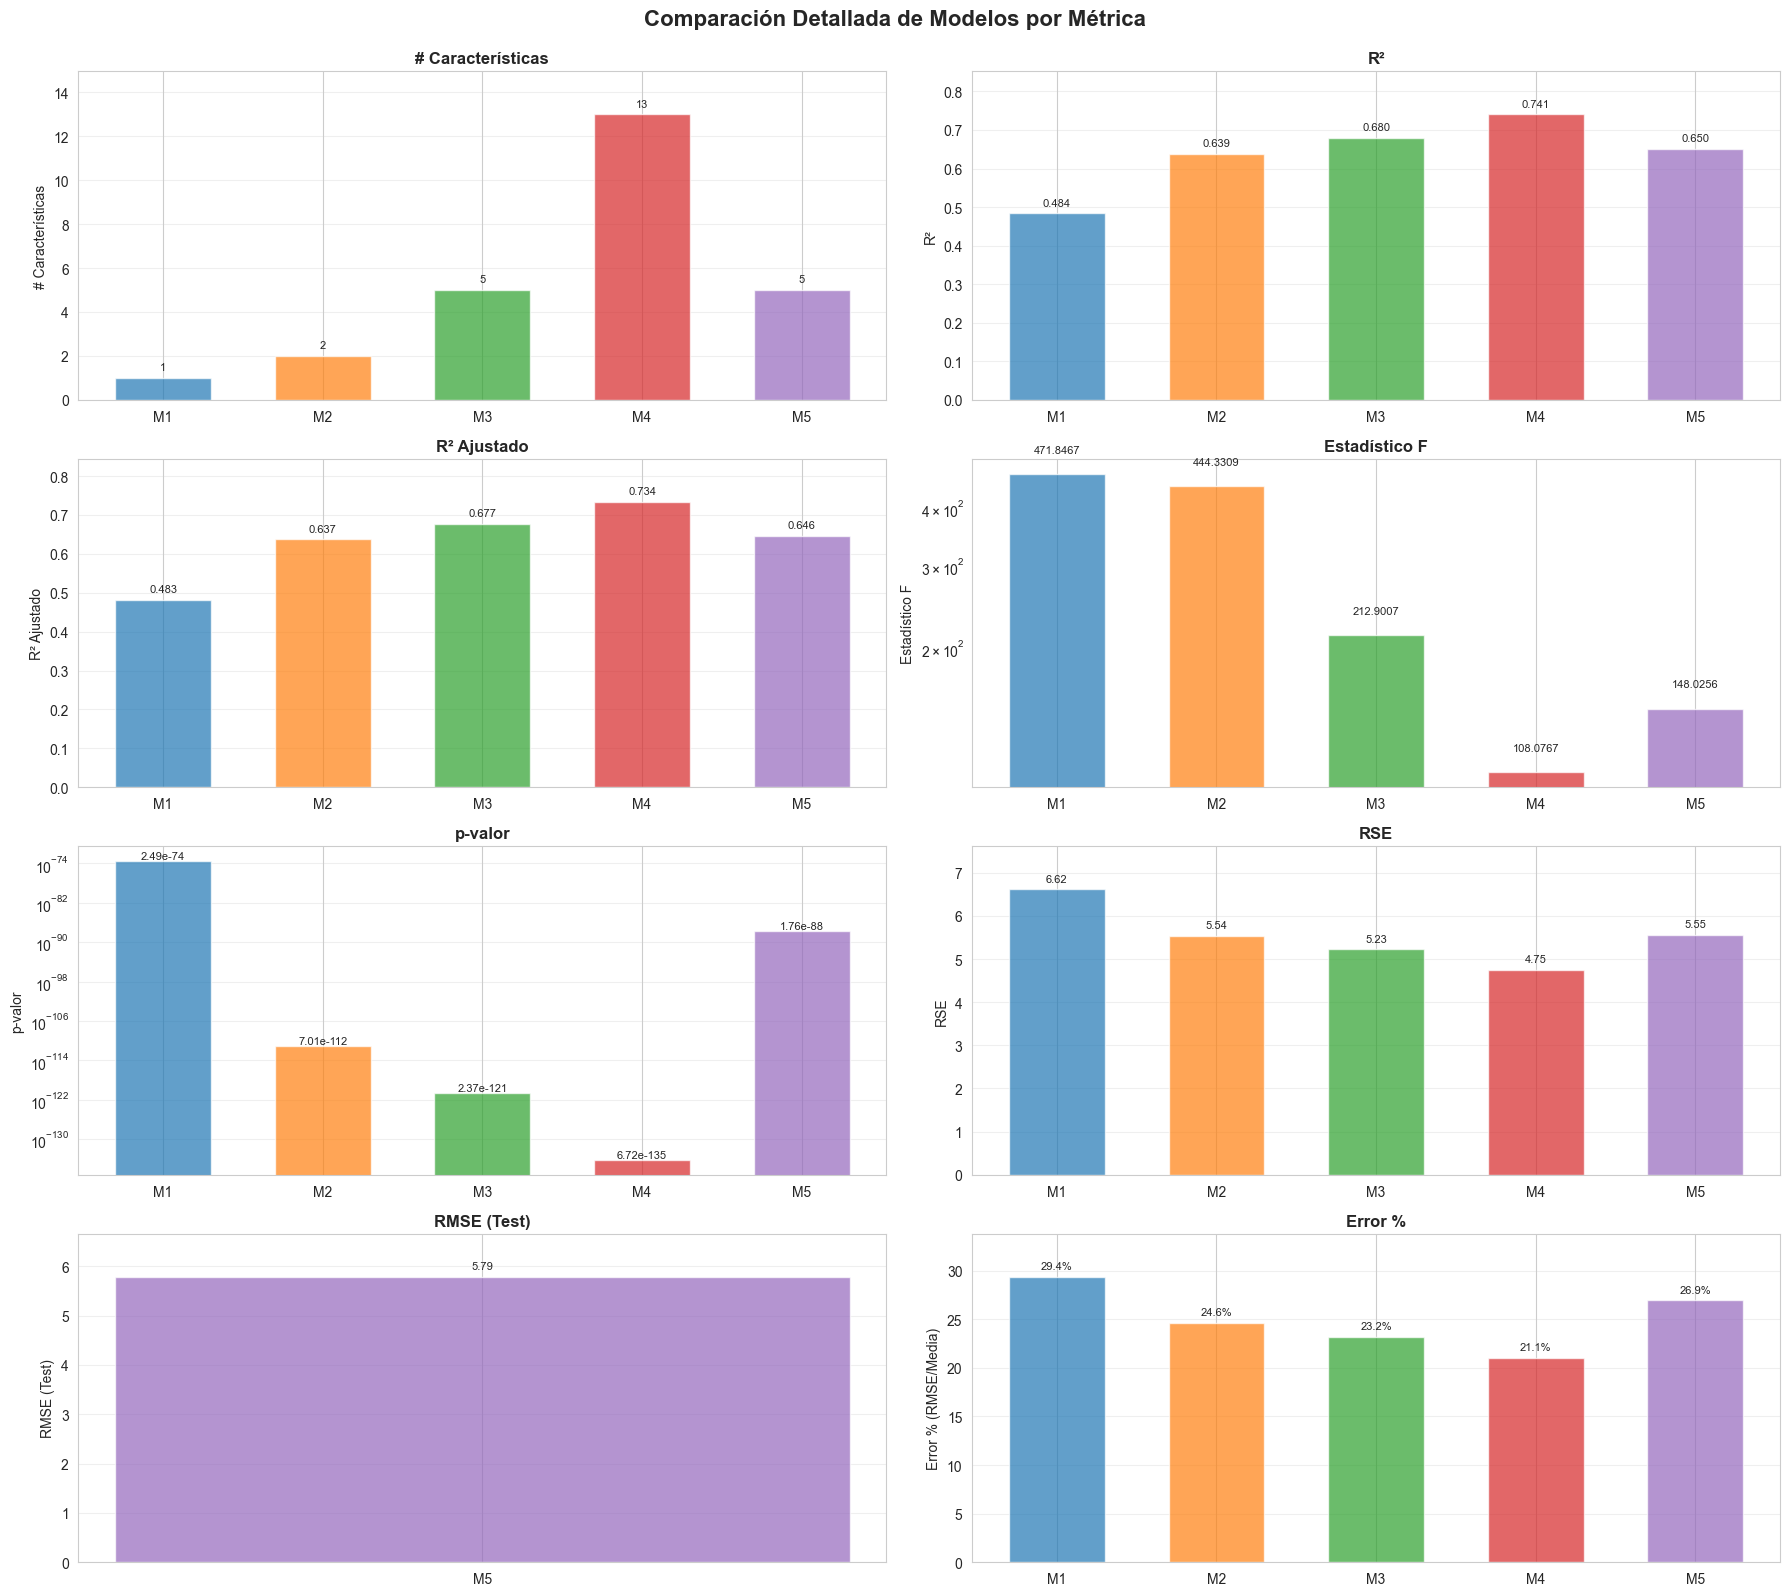


Resumen de Modelos:

M1: Modelo 1 (solo RM)
     Definición: MEDV ~ RM
     Mejor métrica: Modelo base (regresión simple)

M2: Modelo 2 (RM + LSTAT)
     Definición: MEDV ~ RM + LSTAT
     Mejor métrica: Modelo intermedio

M3: Modelo 3 (5 características)
     Definición: MEDV ~ RM + LSTAT + PTRATIO + INDUS + TAX
     Mejor métrica: Modelo intermedio

M4: Modelo 4 (Todas las 13 características)
     Definición: MEDV ~ Todas las características
     Mejor métrica: Mejor R² general

M5: Modelo 5 (RFE - 5 características)
     Definición: MEDV ~ CHAS + NOX + RM + DIS + PTRATIO
     Mejor métrica: Modelo intermedio


In [124]:
# Crear gráfico de barras agrupadas para todas las métricas
fig, axes = plt.subplots(4, 2, figsize=(18, 16))
axes = axes.flatten()

# Colores consistentes para cada modelo
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
model_labels = [f"M{i + 1}" for i in range(len(model_comparison))]

# Métricas a graficar
metrics = [
    ("# Características", "# Características", False, None),
    ("R²", "R²", False, None),
    ("R² Ajustado", "R² Ajustado", False, None),
    ("Estadístico F", "Estadístico F", True, "log"),
    ("p-valor", "p-valor", True, "log"),
    ("RSE", "RSE", False, None),
    ("RMSE (Test)", "RMSE (Test)", False, None),
    ("Error %", "Error % (RMSE/Media)", False, None),
]

for idx, (metric_name, ylabel, use_log, scale) in enumerate(metrics):
    ax = axes[idx]

    # Obtener valores para esta métrica
    values = model_comparison[metric_name].values

    # Filtrar modelos con valores válidos (no None, no NaN)
    valid_indices = [i for i, v in enumerate(values) if pd.notna(v)]
    valid_values = [values[i] for i in valid_indices]
    valid_labels = [model_labels[i] for i in valid_indices]
    valid_colors = [colors[i] for i in valid_indices]

    if len(valid_values) > 0:
        # Crear barras
        x_pos = np.arange(len(valid_values))
        bars = ax.bar(x_pos, valid_values, color=valid_colors, alpha=0.7, width=0.6)

        # Configurar escala logarítmica si es necesario
        if use_log and scale == "log":
            ax.set_yscale("log")

        # Agregar valores sobre las barras
        for i, (bar, value) in enumerate(zip(bars, valid_values)):
            height = bar.get_height()

            # Formato del texto según la métrica
            if metric_name == "# Características":
                text = f"{int(value)}"
            elif metric_name in ["p-valor", "Estadístico F"]:
                text = f"{value:.2e}" if value < 0.01 else f"{value:.4f}"
            elif metric_name in ["R²", "R² Ajustado"]:
                text = f"{value:.3f}"
            elif metric_name == "Error %":
                text = f"{value:.1f}%"
            else:
                text = f"{value:.2f}"

            # Posición del texto
            if use_log:
                ax.text(
                    i,
                    height * 1.1,
                    text,
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    rotation=0,
                )
            else:
                ax.text(
                    i,
                    height + (max(valid_values) * 0.02),
                    text,
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )

        # Configurar ejes
        ax.set_xticks(x_pos)
        ax.set_xticklabels(valid_labels, fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_title(metric_name, fontsize=12, fontweight="bold")
        ax.grid(True, alpha=0.3, axis="y")

        # Ajustar límites del eje Y para mejor visualización
        if not use_log:
            y_max = max(valid_values)
            ax.set_ylim(0, y_max * 1.15)
    else:
        # Si no hay datos válidos, mostrar mensaje
        ax.text(
            0.5,
            0.5,
            "No hay datos\ndisponibles",
            ha="center",
            va="center",
            fontsize=12,
            transform=ax.transAxes,
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(metric_name, fontsize=12, fontweight="bold")

plt.suptitle(
    "Comparación Detallada de Modelos por Métrica",
    fontsize=16,
    fontweight="bold",
    y=0.995,
)

plt.tight_layout()
plt.show()

# Imprimir resumen de cada modelo
print("\nResumen de Modelos:")
print("=" * 80)
for i, row in model_comparison.iterrows():
    print(f"\nM{i + 1}: {row['Modelo']}")
    print(f"     Definición: {row['Definición']}")
    print(f"     Mejor métrica: ", end="")

    # Identificar mejor métrica
    if i == 0:
        print("Modelo base (regresión simple)")
    elif row["R²"] == model_comparison["R²"].max():
        print("Mejor R² general")
    elif row["R² Ajustado"] == model_comparison["R² Ajustado"].max():
        print("Mejor R² ajustado")
    elif pd.notna(row["RSE"]) and row["RSE"] == model_comparison["RSE"].min():
        print("Menor RSE")
    else:
        print("Modelo intermedio")

print("=" * 80)